In [ ]:
-import cv2
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ./datasets

In [ ]:
!unzip -qo '/content/drive/MyDrive/datasets/train-data-shadow-affected.zip' -d "/content/datasets/train_data_shadow" & unzip -qo "/content/drive/MyDrive/datasets/train-data-shadow-free.zip" -d "/content/datasets/train_data_free" & unzip -qo "/content/drive/MyDrive/datasets/validate.zip" -d "/content/datasets/validate"

In [ ]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
def build_shadow_removal_model(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Decoder
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    return model

In [ ]:
non_shadow_dir = '/content/datasets/train_data_free/'


In [ ]:
shadow_dir = '/content/datasets/train_data_shadow/'


In [ ]:
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images


In [ ]:
shadow_images = load_images_from_dir(shadow_dir)
non_shadow_images = load_images_from_dir(non_shadow_dir)

In [ ]:
shadow_labels = np.ones(len(shadow_images))
non_shadow_labels = np.zeros(len(non_shadow_images))


In [ ]:
all_images = np.array(shadow_images + non_shadow_images)
all_labels = np.concatenate((shadow_labels, non_shadow_labels))

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)


In [ ]:
all_images.shape

(2000, 1440, 1920)

In [ ]:
all_labels.shape


(2000,)

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Directory containing images
image_dir = '/content/datasets/train_data_free/'


In [ ]:

# Function to load and preprocess images in batches
def image_batch_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, num_samples, batch_size)]
    while True:
        for batch_indices in batches:
            batch_images = [cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE) for i in batch_indices]
            batch_images = np.array(batch_images) / 255.0
            batch_images = batch_images[..., np.newaxis]
            batch_labels = labels[batch_indices]
            yield batch_images, batch_labels




In [ ]:
# Get paths to all images
image_paths = []
for filename in os.listdir(image_dir):
    image_paths.append(os.path.join(image_dir, filename))



In [ ]:
# Create labels for the images (1 for shadow, 0 for non-shadow)
labels = np.array([1 if 'shadow' in path else 0 for path in image_paths])

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Parameters
batch_size = 32

# Create generators for training and testing data
train_generator = image_batch_generator(train_paths, train_labels, batch_size)
test_generator = image_batch_generator(test_paths, test_labels, batch_size)

In [ ]:
input_shape = (1440, 1920, 1)  # Assuming grayscale images
batch_size = 32
epochs = 10


In [ ]:
model = build_shadow_removal_model(input_shape)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
train_steps_per_epoch = len(train_paths) // batch_size
test_steps_per_epoch = len(test_paths) // batch_size

In [ ]:
model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=epochs,
          validation_data=test_generator, validation_steps=test_steps_per_epoch)

## ------------------------------------------------------------------

In [ ]:
img = cv2.imread(r'/content/ivp_img1.png')


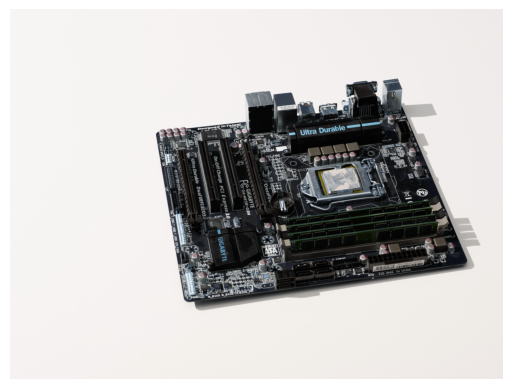

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)



In [ ]:
lower_shadow = np.array([0, 50, 50])
upper_shadow = np.array([179, 100, 100])


In [ ]:

# Create a mask for shadow regions
mask = cv2.inRange(hsv, lower_shadow, upper_shadow)


In [ ]:

# Apply morphological operations to refine the mask
kernel = np.ones((10, 10), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)



In [ ]:
# Inpaint shadow regions
result = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)


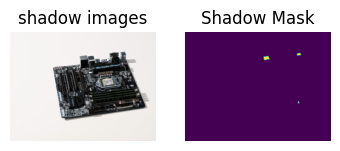

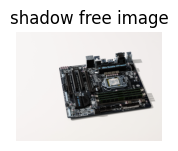

In [ ]:

# Display the results
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis('off')
plt.title('shadow images')
plt.subplot(1,3,2)
plt.imshow(mask)
plt.axis('off')
plt.title('Shadow Mask')
plt.show()
plt.subplot(1,3,3)
plt.imshow(result)
plt.axis('off')
plt.title('shadow free image')
plt.show()


# ----------------------------

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch


In [ ]:
def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find(
                'Linear') == 0) and hasattr(m, 'weight'):
            if init_type == 'gaussian':
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    return init_fun


class Cvi(nn.Module):
    def __init__(self, in_channels, out_channels, before=None, after=False, kernel_size=4, stride=2,
                 padding=1, dilation=1, groups=1, bias=False):
        super(Cvi, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv.apply(weights_init('gaussian'))

        if after=='BN':
            self.after = nn.BatchNorm2d(out_channels)
        elif after=='Tanh':
            self.after = torch.tanh
        elif after=='sigmoid':
            self.after = torch.sigmoid

        if before=='ReLU':
            self.before = nn.ReLU(inplace=True)
        elif before=='LReLU':
            self.before = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):

        if hasattr(self, 'before'):
            x = self.before(x)

        x = self.conv(x)

        if hasattr(self, 'after'):
            x = self.after(x)

        return x


class CvTi(nn.Module):
    def __init__(self, in_channels, out_channels, before=None, after=False, kernel_size=4, stride=2,
                 padding=1, dilation=1, groups=1, bias=False):
        super(CvTi, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
        self.conv.apply(weights_init('gaussian'))

        if after=='BN':
            self.after = nn.BatchNorm2d(out_channels)
        elif after=='Tanh':
            self.after = torch.tanh
        elif after=='sigmoid':
            self.after = torch.sigmoid

        if before=='ReLU':
            self.before = nn.ReLU(inplace=True)
        elif before=='LReLU':
            self.before = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):

        if hasattr(self, 'before'):
            x = self.before(x)

        x = self.conv(x)

        if hasattr(self, 'after'):
            x = self.after(x)

        return x

class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(Generator, self).__init__()

        self.Cv0 = Cvi(input_channels, 64)

        self.Cv1 = Cvi(64, 128, before='LReLU', after='BN')

        self.Cv2 = Cvi(128, 256, before='LReLU', after='BN')

        self.Cv3 = Cvi(256, 512, before='LReLU', after='BN')

        self.Cv4 = Cvi(512, 512, before='LReLU', after='BN')

        self.Cv5 = Cvi(512, 512, before='LReLU')

        self.CvT6 = CvTi(512, 512, before='ReLU', after='BN')

        self.CvT7 = CvTi(1024, 512, before='ReLU', after='BN')

        self.CvT8 = CvTi(1024, 256, before='ReLU', after='BN')

        self.CvT9 = CvTi(512, 128, before='ReLU', after='BN')

        self.CvT10 = CvTi(256, 64, before='ReLU', after='BN')

        self.CvT11 = CvTi(128, output_channels, before='ReLU', after='Tanh')

    def forward(self, input):
        #encoder
        x0 = self.Cv0(input)
        x1 = self.Cv1(x0)
        x2 = self.Cv2(x1)
        x3 = self.Cv3(x2)
        x4_1 = self.Cv4(x3)
        x4_2 = self.Cv4(x4_1)
        x4_3 = self.Cv4(x4_2)
        x5 = self.Cv5(x4_3)

        #decoder
        x6 = self.CvT6(x5)

        cat1_1 = torch.cat([x6, x4_3], dim=1)
        x7_1 = self.CvT7(cat1_1)
        cat1_2 = torch.cat([x7_1, x4_2], dim=1)
        x7_2 = self.CvT7(cat1_2)
        cat1_3 = torch.cat([x7_2, x4_1], dim=1)
        x7_3 = self.CvT7(cat1_3)

        cat2 = torch.cat([x7_3, x3], dim=1)
        x8 = self.CvT8(cat2)

        cat3 = torch.cat([x8, x2], dim=1)
        x9 = self.CvT9(cat3)

        cat4 = torch.cat([x9, x1], dim=1)
        x10 = self.CvT10(cat4)

        cat5 = torch.cat([x10, x0], dim=1)
        out = self.CvT11(cat5)

        return out

class Discriminator(nn.Module):
    def __init__(self, input_channels=4):
        super(Discriminator, self).__init__()

        self.Cv0 = Cvi(input_channels, 64)

        self.Cv1 = Cvi(64, 128, before='LReLU', after='BN')

        self.Cv2 = Cvi(128, 256, before='LReLU', after='BN')

        self.Cv3 = Cvi(256, 512, before='LReLU', after='BN')

        self.Cv4 = Cvi(512, 1, before='LReLU', after='sigmoid')

    def forward(self, input):
        x0 = self.Cv0(input)
        x1 = self.Cv1(x0)
        x2 = self.Cv2(x1)
        x3 = self.Cv3(x2)
        out = self.Cv4(x3)

        return out

if __name__ == '__main__':
    #BCHW
    size = (3, 3, 256, 256)
    input = torch.ones(size)
    l1 = nn.L1Loss()
    input.requires_grad = True


In [ ]:
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.autograd import Variable
from collections import OrderedDict
from torchvision import models
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import argparse
import time
import torch
import os

In [ ]:
## Utils

In [ ]:
import numbers
import random
import warnings
from collections.abc import Sequence
from typing import Tuple, List, Optional

import torch
from PIL import Image
from torch import Tensor
import torchvision.transforms.functional as F

In [ ]:
#refered https://github.com/pytorch/vision/blob/master/torchvision/transforms/transforms.py

import math
import numbers
import random
import warnings
from collections.abc import Sequence
from typing import Tuple, List, Optional

import torch
from PIL import Image
from torch import Tensor
import torchvision.transforms.functional as F


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class ToTensor(object):
    def __call__(self, pic):
        return F.to_tensor(pic[0]), F.to_tensor(pic[1]), F.to_tensor(pic[2])

    def __repr__(self):
        return self.__class__.__name__ + '()'


class Scale(object):
  def __init__(self, size, interpolation=Image.BILINEAR):
    self.size = size
    self.interpolation = interpolation

  def __call__(self, imgs):
    output = []
    for img in imgs:
      w, h = img.size
      if (w <= h and w == self.size) or (h <= w and h == self.size):
        output.append(img)
        continue
      if w < h:
        ow = self.size
        oh = int(self.size * h / w)
        output.append(img.resize((ow, oh), self.interpolation))
        continue
      else:
        oh = self.size
        ow = int(self.size * w / h)
      output.append(img.resize((ow, oh), self.interpolation))
    return output[0], output[1], output[2]


class Normalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, tensor):
        return F.normalize(tensor[0], self.mean, self.std, self.inplace), F.normalize(tensor[1], self.mean, self.std, self.inplace), F.normalize(tensor[2], self.mean, self.std, self.inplace)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class CenterCrop(torch.nn.Module):
    def __init__(self, size):
        super().__init__()
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        elif isinstance(size, Sequence) and len(size) == 1:
            self.size = (size[0], size[0])
        else:
            if len(size) != 2:
                raise ValueError("Please provide only two dimensions (h, w) for size.")

            self.size = size

    def forward(self, img):
        return F.center_crop(img[0], self.size), F.center_crop(img[1], self.size), F.center_crop(img[2], self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class RandomCrop(torch.nn.Module):
    @staticmethod
    def get_params(img: Tensor, output_size: Tuple[int, int]) -> Tuple[int, int, int, int]:
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, h - th + 1, size=(1, )).item()
        j = torch.randint(0, w - tw + 1, size=(1, )).item()
        return i, j, th, tw

    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode="constant"):
        super().__init__()
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        elif isinstance(size, Sequence) and len(size) == 1:
            self.size = (size[0], size[0])
        else:
            if len(size) != 2:
                raise ValueError("Please provide only two dimensions (h, w) for size.")

            # cast to tuple for torchscript
            self.size = tuple(size)
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    def forward(self, img):
        if self.padding is not None:
            img[0] = F.pad(img[0], self.padding, self.fill, self.padding_mode)

        width, height = img[0].size
        # pad the width if needed
        if self.pad_if_needed and width < self.size[1]:
            padding = [self.size[1] - width, 0]
            img[0] = F.pad(img[0], padding, self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and height < self.size[0]:
            padding = [0, self.size[0] - height]
            img[0] = F.pad(img[0], padding, self.fill, self.padding_mode)

        i, j, h, w = self.get_params(img[0], self.size)

        return F.crop(img[0], i, j, h, w), F.crop(img[1], i, j, h, w), F.crop(img[2], i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + "(size={0}, padding={1})".format(self.size, self.padding)


class RandomHorizontalFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        if torch.rand(1) < self.p:
            return F.hflip(img[0]), F.hflip(img[1]), F.hflip(img[2])
        return img[0], img[1], img[2]

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

In [ ]:
## data loader

In [ ]:
import os
import glob
import torch
import torch.utils.data as data
from PIL import Image
import random
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:


def make_datapath_list(phase="train", rate=0.8):
    """
    make filepath list for train, validation and test images
    """
    random.seed(44)

    rootpath = './dataset/' + phase + '/'
    files_name = os.listdir(rootpath + phase + '_A')

    if phase=='train':
        random.shuffle(files_name)
    elif phase=='test':
        files_name.sort()

    path_A = []
    path_B = []
    path_C = []

    for name in files_name:
        path_A.append(rootpath + phase + '_A/'+name)
        path_B.append(rootpath + phase + '_B/'+name)
        path_C.append(rootpath + phase + '_C/'+name)

    num = len(path_A)

    if phase=='train':
        path_A, path_A_val = path_A[:int(num*rate)], path_A[int(num*rate):]
        path_B, path_B_val = path_B[:int(num*rate)], path_B[int(num*rate):]
        path_C, path_C_val = path_C[:int(num*rate)], path_C[int(num*rate):]
        path_list = {'path_A': path_A, 'path_B': path_B, 'path_C': path_C}
        path_list_val = {'path_A': path_A_val, 'path_B': path_B_val, 'path_C': path_C_val}
        return path_list, path_list_val

    elif phase=='test':
        path_list = {'path_A': path_A, 'path_B': path_B, 'path_C': path_C}
        return path_list

In [ ]:
class ImageDataset(data.Dataset):
    """
    Dataset class. Inherit Dataset class from PyTrorch.
    """
    def __init__(self, img_list, img_transform, phase):
        self.img_list = img_list
        self.img_transform = img_transform
        self.phase = phase

    def __len__(self):
        return len(self.img_list['path_A'])

    def __getitem__(self, index):
        '''
        get tensor type preprocessed Image
        '''
        img = Image.open(self.img_list['path_A'][index]).convert('RGB')
        gt_shadow = Image.open(self.img_list['path_B'][index])
        gt = Image.open(self.img_list['path_C'][index]).convert('RGB')

        img, gt_shadow, gt = self.img_transform(self.phase, [img, gt_shadow, gt])

        return img, gt_shadow, gt

In [ ]:
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.autograd import Variable
from collections import OrderedDict
from torchvision import models
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import argparse
import time
import torch
import os

In [ ]:
torch.manual_seed(44)
# choose your device
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [ ]:
def get_parser():
    parser = argparse.ArgumentParser(
        prog='ST-CGAN: Stacked Conditional Generative Adversarial Networks for Jointly Learning Shadow Detection and Shadow Removal',
        usage='python3 main.py',
        description='This module demonstrates shadow detection and removal using ST-CGAN.',
        add_help=True)

    parser.add_argument('-e', '--epoch', type=int, default=10000, help='Number of epochs')
    parser.add_argument('-b', '--batch_size', type=int, default=8, help='Batch size')
    parser.add_argument('-l', '--load', type=str, default=None, help='the number of checkpoints')
    parser.add_argument('-hor', '--hold_out_ratio', type=float, default=0.8, help='training-validation ratio')
    parser.add_argument('-s', '--image_size', type=int, default=286)
    parser.add_argument('-cs', '--crop_size', type=int, default=256)
    parser.add_argument('-lr', '--lr', type=float, default=2e-4)

    return parser

In [ ]:
def fix_model_state_dict(state_dict):
    '''
    remove 'module.' of dataparallel
    '''
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if name.startswith('module.'):
            name = name[7:]
        new_state_dict[name] = v
    return new_state_dict

def set_requires_grad(nets, requires_grad=False):
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

def unnormalize(x):
    x = x.transpose(1, 3)
    #mean, std
    x = x * torch.Tensor((0.5, )) + torch.Tensor((0.5, ))
    x = x.transpose(1, 3)
    return x

In [ ]:
def evaluate(G1, G2, dataset, device, filename):
    img, gt_shadow, gt = zip(*[dataset[i] for i in range(8)])
    img = torch.stack(img)
    gt_shadow = torch.stack(gt_shadow)
    gt = torch.stack(gt)

    with torch.no_grad():
        detected_shadow = G1(img.to(device))
        detected_shadow = detected_shadow.to(torch.device('cpu'))
        concat = torch.cat([img, detected_shadow], dim=1)
        shadow_removal_image = G2(concat.to(device))
        shadow_removal_image = shadow_removal_image.to(torch.device('cpu'))

    grid_detect = make_grid(torch.cat((unnormalize(gt_shadow), unnormalize(detected_shadow)), dim=0))
    grid_removal = make_grid(torch.cat((unnormalize(img), unnormalize(gt), unnormalize(shadow_removal_image)), dim=0))

    save_image(grid_detect, filename+'_detect.jpg')
    save_image(grid_removal, filename+'_removal.jpg')

In [ ]:
def plot_log(data, save_model_name='model'):
    plt.cla()
    plt.plot(data['G'], label='G_loss ')
    plt.plot(data['D'], label='D_loss ')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.savefig('./logs/'+save_model_name+'.png')

def check_dir():
    if not os.path.exists('./logs'):
        os.mkdir('./logs')
    if not os.path.exists('./checkpoints'):
        os.mkdir('./checkpoints')
    if not os.path.exists('./result'):
        os.mkdir('./result')

def train_model(G1, G2, D1, D2, dataloader, val_dataset, num_epochs, parser, save_model_name='model'):

    check_dir()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    G1.to(device)
    G2.to(device)
    D1.to(device)
    D2.to(device)

    """use GPU in parallel"""
    if device == 'cuda':
        G1 = torch.nn.DataParallel(G1)
        G2 = torch.nn.DataParallel(G2)
        D1 = torch.nn.DataParallel(D1)
        D2 = torch.nn.DataParallel(D2)
        print("parallel mode")

    print("device:{}".format(device))

    lr = parser.lr
    beta1, beta2 = 0.5, 0.999

    optimizerG = torch.optim.Adam([{'params': G1.parameters()}, {'params': G2.parameters()}],
                                  lr=lr,
                                  betas=(beta1, beta2))
    optimizerD = torch.optim.Adam([{'params': D1.parameters()}, {'params': D2.parameters()}],
                                  lr=lr,
                                  betas=(beta1, beta2))

    criterionGAN = nn.BCEWithLogitsLoss().to(device)
    criterionL1 = nn.L1Loss().to(device)

    torch.backends.cudnn.benchmark = True

    mini_batch_size = parser.batch_size
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    lambda_dict = {'lambda1':5, 'lambda2':0.1, 'lambda3':0.1}

    iteration = 1
    g_losses = []
    d_losses = []

    for epoch in range(num_epochs+1):

        G1.train()
        G2.train()
        D1.train()
        D2.train()
        t_epoch_start = time.time()

        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print('-----------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('(train)')

        for images, gt_shadow, gt in tqdm(dataloader):

            # if size of minibatch is 1, an error would be occured.
            if images.size()[0] == 1:
                continue

            images = images.to(device)
            gt = gt.to(device)
            gt_shadow = gt_shadow.to(device)

            mini_batch_size = images.size()[0]

            # Train Discriminator
            set_requires_grad([D1, D2], True)  # enable backprop$
            optimizerD.zero_grad()

            # for D1
            detected_shadow = G1(images)
            fake1 = torch.cat([images, detected_shadow], dim=1)
            real1 = torch.cat([images, gt_shadow], dim=1)
            out_D1_fake = D1(fake1.detach())
            out_D1_real = D1(real1)# .detach() is not required as real1 doesn't have grad

            # for D2
            shadow_removal_image = G2(fake1)
            fake2 = torch.cat([fake1, shadow_removal_image], dim=1)
            real2 = torch.cat([real1, gt], dim=1)
            out_D2_fake = D2(fake2.detach())
            out_D2_real = D2(real2)# .detach() is not required as real2 doesn't have grad

            # L_CGAN1
            label_D1_fake = Variable(Tensor(np.zeros(out_D1_fake.size())), requires_grad=True)
            label_D1_real = Variable(Tensor(np.ones(out_D1_fake.size())), requires_grad=True)

            loss_D1_fake = criterionGAN(out_D1_fake, label_D1_fake)
            loss_D1_real = criterionGAN(out_D1_real, label_D1_real)
            D_L_CGAN1 = loss_D1_fake + loss_D1_real

            # L_CGAN2
            label_D2_fake = Variable(Tensor(np.zeros(out_D2_fake.size())), requires_grad=True)
            label_D2_real = Variable(Tensor(np.ones(out_D2_fake.size())), requires_grad=True)

            loss_D2_fake = criterionGAN(out_D2_fake, label_D2_fake)
            loss_D2_real = criterionGAN(out_D2_real, label_D2_real)
            D_L_CGAN2 = loss_D2_fake + loss_D2_real

            # total
            D_loss = lambda_dict['lambda2'] * D_L_CGAN1 + lambda_dict['lambda3'] * D_L_CGAN2
            D_loss.backward()
            optimizerD.step()

            # Train Generator
            set_requires_grad([D1, D2], False)
            optimizerG.zero_grad()

            # L_CGAN1
            fake1 = torch.cat([images, detected_shadow], dim=1)
            out_D1_fake = D1(fake1.detach())
            G_L_CGAN1 = criterionGAN(out_D1_fake, label_D1_real)

            # L_data1
            G_L_data1 = criterionL1(detected_shadow, gt_shadow)

            # L_CGAN2
            fake2 = torch.cat([fake1, shadow_removal_image], dim=1)
            out_D2_fake = D2(fake2.detach())
            G_L_CGAN2 = criterionGAN(out_D2_fake, label_D2_real)

            #L_data2
            G_L_data2 = criterionL1(gt, shadow_removal_image)

            #total
            G_loss = G_L_data1 + lambda_dict['lambda1'] * G_L_data2 + lambda_dict['lambda2'] * G_L_CGAN1 + lambda_dict['lambda3'] * G_L_CGAN2
            G_loss.backward()
            optimizerG.step()

            epoch_d_loss += D_loss.item()
            epoch_g_loss += G_loss.item()

        t_epoch_finish = time.time()
        print('-----------')
        print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

        d_losses += [epoch_d_loss/batch_size]
        g_losses += [epoch_g_loss/batch_size]
        t_epoch_start = time.time()
        plot_log({'G':g_losses, 'D':d_losses}, save_model_name)

        if(epoch%10 == 0):
            torch.save(G1.state_dict(), 'checkpoints/'+save_model_name+'_G1_'+str(epoch)+'.pth')
            torch.save(G2.state_dict(), 'checkpoints/'+save_model_name+'_G2_'+str(epoch)+'.pth')
            torch.save(D1.state_dict(), 'checkpoints/'+save_model_name+'_D1_'+str(epoch)+'.pth')
            torch.save(D2.state_dict(), 'checkpoints/'+save_model_name+'_D2_'+str(epoch)+'.pth')
            G1.eval()
            G2.eval()
            evaluate(G1, G2, val_dataset, device, '{:s}/val_{:d}'.format('result', epoch))

    return G1, G2, D1, D2
